# Installs

In [1]:
!pip install deeptrack
!pip install tensorflow
!/usr/local/cuda/bin/nvcc --version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


# Imports

In [2]:
import deeptrack as dt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.layers import Layer, Dense, Attention, Concatenate, Conv1D, Dropout, LayerNormalization, LeakyReLU, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import pdb
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Generate data

In [3]:
IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv


particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)

dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()

Plots

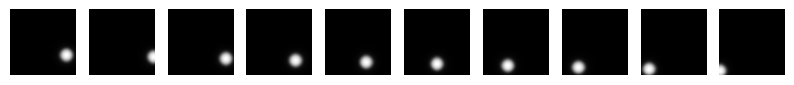

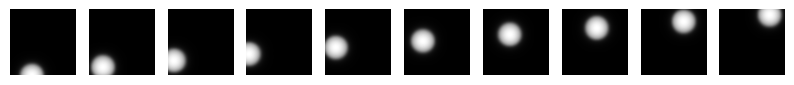

In [4]:
k=0
for sample_sequence in dataset:
    if k >= 2:
        break
    fig, axs = plt.subplots(1, sequence_length, figsize=(10, 3))
    for i in range(sequence_length):
        axs[i].imshow(sample_sequence[i][:, :, 0], cmap='gray')
        axs[i].axis('off')
    plt.show()
    k += 1

# Variables

In [5]:
data_amount = 1000
seq_len = 9
latent_dim = 10
n_heads = 3
d_k= 12
d_v= d_k 
VERBOSE = False
#VERBOSE = True
# Good result from 16 4 and 16

# Choose dataset

In [6]:
frames = []
for i in range(data_amount):
    video = dataset.update().resolve() 
    for frame in video:
        frames.append(frame)

if VERBOSE:
  print(frames[0].shape)    
  print(len(frames))

In [7]:
num_samples = len(frames)
split = 0.05
train_data = tf.stack(frames[int(split* num_samples):])
test_data = tf.stack(frames[:int(split * num_samples)])
if VERBOSE:
  print(len(train_data))

# Autoencoder

In [8]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(latent_dim)
      ]) # Dimension: (None, latent_dim)

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
      tf.keras.layers.Dense(units=8 * 8 * 64, activation=tf.nn.relu),
      tf.keras.layers.Reshape(target_shape=(8, 8, 64)),
      tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same', activation='relu'),
      tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=4, strides=2, padding='same', activation='relu'),
      tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding='same', activation='linear')
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.build((None, 64, 64, 1))
if VERBOSE:
  autoencoder.encoder.summary()
  autoencoder.decoder.summary()

# Train the autoencoder

In [9]:
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
autoencoder.fit(train_data, train_data,
                epochs=100,
                shuffle=True,
                validation_data=(test_data, test_data),
                callbacks=[callback])
autoencoder.trainable = False

Epoch 1/100
297/297 [==============================] - 8s 10ms/step - loss: 5.1795 - val_loss: 1.4696
Epoch 2/100
297/297 [==============================] - 2s 6ms/step - loss: 1.4609 - val_loss: 1.4446
Epoch 3/100
297/297 [==============================] - 2s 6ms/step - loss: 1.1609 - val_loss: 0.8937
Epoch 4/100
297/297 [==============================] - 2s 6ms/step - loss: 0.9390 - val_loss: 0.5204
Epoch 5/100
297/297 [==============================] - 2s 6ms/step - loss: 0.6693 - val_loss: 0.3125
Epoch 6/100
297/297 [==============================] - 2s 6ms/step - loss: 0.5745 - val_loss: 0.2846
Epoch 7/100
297/297 [==============================] - 2s 7ms/step - loss: 0.5012 - val_loss: 0.4718
Epoch 8/100
297/297 [==============================] - 2s 7ms/step - loss: 0.4063 - val_loss: 0.2270
Epoch 9/100
297/297 [==============================] - 2s 6ms/step - loss: 0.3972 - val_loss: 0.2334
Epoch 10/100
297/297 [==============================] - 2s 6ms/step - loss: 0.3979 - val_l

# Plot

In [ ]:
def plot_comparasion(decoded, train_data, num_pics=10):
  plt.figure(figsize=(20, 4))
  for i in range(num_pics):
    # Original
    ax = plt.subplot(2, num_pics, i + 1)
    plt.imshow(train_data[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed
    ax = plt.subplot(2, num_pics, i + 1 + num_pics)
    plt.imshow(decoded[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

def plot_detailed(decoded, train_data):
  plt.figure(figsize=(12, 6))
  # Original
  ax1 = plt.subplot(1, 2, 1)
  plt.imshow(train_data[0])
  ax1.axis('off')
  # Reconstructed
  ax2 = plt.subplot(1, 2, 2)
  plt.imshow(decoded[0])
  ax2.axis('off')
  plt.show()

def plot_loss_history(history):
  # Train and validation loss
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot loss history
  plt.plot(train_loss, label='train')
  plt.plot(val_loss, label='val')
  plt.title('Training and validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
encoded = autoencoder.encoder(train_data).numpy()
decoded = autoencoder.decoder(encoded).numpy()
plot_comparasion(decoded, train_data)
if VERBOSE:
  plot_detailed(decoded, train_data)

# Time2vec and SingleAttention


In [12]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    self.weights_linear = self.add_weight(name='weight_linear', shape=(int(self.seq_len),), initializer='uniform',trainable=True)
    self.bias_linear = self.add_weight(name='bias_linear', shape=(int(self.seq_len),), initializer='uniform',trainable=True)
    self.weights_periodic = self.add_weight(name='weight_periodic', shape=(int(self.seq_len),), initializer='uniform',trainable=True)
    self.bias_periodic = self.add_weight(name='bias_periodic', shape=(int(self.seq_len),), initializer='uniform',trainable=True)
    
  def call(self, x):
    x = tf.math.reduce_mean(x[:,:,:], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1)
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1)
    
    return tf.concat([time_linear, time_periodic], axis=-1)

class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
  
  def build(self, input_shape):
    self.query = Dense(self.d_k, input_shape=input_shape,kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.key = Dense(self.d_k, input_shape=input_shape,kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.value = Dense(self.d_v, input_shape=input_shape,kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
  
  def call(self, input): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(input)
    k = self.key(input)
    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    v = self.value(input)
    attn_out = tf.matmul(attn_weights, v)

    return attn_out

# Multihead attention

In [13]:
class MultiHeadAttention(Layer):
    def __init__(self, nr_heads, d_k, d_v, latent_dim, **kwargs):
      super(MultiHeadAttention, self).__init__()
      self.d_k = d_k
      self.d_v = d_v
      self.nr_heads = nr_heads
      self.attn_heads = list()
      self.latent_dim = latent_dim
      self.depth_per_head = int((latent_dim+2)/nr_heads)

    def build(self, input_shape): # Batch seq_len latdim+2
      for i in range(self.nr_heads):
        self.attn_heads.append(SingleAttention(self.d_k,self.d_v))
      self.linear1 = Dense(self.latent_dim+2, input_shape=input_shape)

    def call(self, x):
      outputs = [self.attn_heads[i](x) for i in range(self.nr_heads)]
      concated = Concatenate(axis=-1)(outputs)
      multi_attention = self.linear1(concated) # Batch_size, seq_len, latent_dim+2      
      return multi_attention 

# Transformer

In [14]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v,latent_dim, n_heads, **kwargs):
      super(TransformerEncoder, self).__init__()
      self.d_k = d_k
      self.d_v = d_v
      self.n_heads=n_heads
      self.latent_dim=latent_dim

    def build(self,input_shape):
      self.multiHeadAtt = MultiHeadAttention(self.n_heads, self.d_k, self.d_v, self.latent_dim)
      self.linear1 = Dense(self.latent_dim+2)
      self.norm = LayerNormalization()
      self.dropout = Dropout(.5)

    def call(self, x): # Batch_size, seq_len, latent_dim+2
      tmp_x = self.multiHeadAtt(x)
      tmp_x = self.dropout(tmp_x)
      tmp_x = self.norm(x + tmp_x)
      tmp_x = self.linear1(tmp_x)
      tmp_x = self.norm(x + tmp_x)
      return tmp_x

# Global model

In [15]:
class GlobalModel(Model):
  """This model takes input from the encoder and spits out the next frame"""

  def __init__(self, seq_len, latent_dim, n_heads, d_k, d_v):
    super(GlobalModel, self).__init__()
    self.latent_dim = latent_dim
    self.seq_len = seq_len
    self.dropout = Dropout(.5)
    self.time_embedding = Time2Vector(seq_len)
    
    self.transformer1 = TransformerEncoder(d_k, d_v,latent_dim, n_heads)
    self.transformer2 = TransformerEncoder(d_k, d_v,latent_dim, n_heads)
    self.transformer3 = TransformerEncoder(d_k, d_v,latent_dim, n_heads)
    
    self.dense1 = Dense(64, activation='relu')
    self.dense2 = Dense(128, activation='relu')
    self.dense3 = Dense(64, activation='relu')
    self.dense_final = Dense(latent_dim)
    

  def call(self, inputs): # Batch_size, seq_len, latent_dim
    x = self.time_embedding(inputs)
    x = Concatenate(axis=-1)([inputs, x]) # Batch_size, seq_len, latent_dim+2
    x = self.transformer1(x)
    x = self.transformer2(x)
    x = self.transformer3(x)

    x = Flatten()(x)
    x = self.dense1(x)
    x = self.dropout(x)
    x = self.dense2(x)
    x = self.dropout(x)
    x = self.dense3(x)
    x = self.dense_final(x) # Batch_size, latent_dim
    return x

# Train

In [16]:
# Prepare data
encoded_train = autoencoder.encoder(train_data)
encoded_test  = autoencoder.encoder(test_data)

train_reshaped = tf.reshape(encoded_train,(int(len(train_data)/10), 10,latent_dim))
train_x = train_reshaped[:,:9,:]
train_y = train_reshaped[:,9,:]

test_reshaped = tf.reshape(encoded_test,(int(len(test_data)/10),10,latent_dim))
test_x = test_reshaped[:,:9,:]
test_y = test_reshaped[:,9,:]

Epoch 1/100
30/30 [==============================] - 25s 246ms/step - loss: 834.2883 - val_loss: 709.0338
Epoch 2/100
30/30 [==============================] - 5s 160ms/step - loss: 743.6008 - val_loss: 612.2324
Epoch 3/100
30/30 [==============================] - 6s 195ms/step - loss: 669.1650 - val_loss: 509.5386
Epoch 4/100
30/30 [==============================] - 5s 158ms/step - loss: 600.4328 - val_loss: 489.8654
Epoch 5/100
30/30 [==============================] - 6s 196ms/step - loss: 567.4900 - val_loss: 449.2129
Epoch 6/100
30/30 [==============================] - 5s 159ms/step - loss: 532.0741 - val_loss: 410.3808
Epoch 7/100
30/30 [==============================] - 6s 196ms/step - loss: 493.8480 - val_loss: 369.6945
Epoch 8/100
30/30 [==============================] - 5s 163ms/step - loss: 494.8415 - val_loss: 382.8439
Epoch 9/100
30/30 [==============================] - 5s 165ms/step - loss: 484.2963 - val_loss: 357.5309
Epoch 10/100
30/30 [==============================] - 

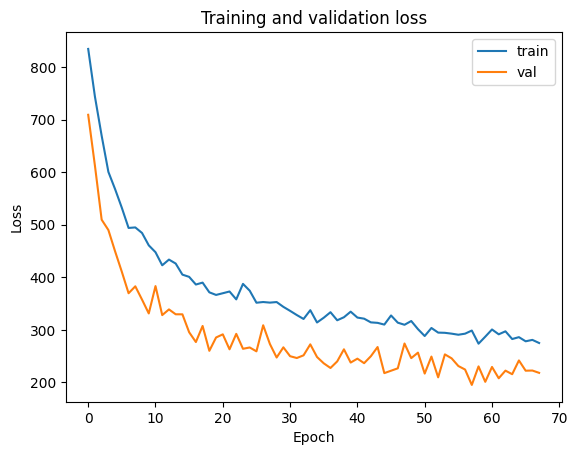

In [17]:
model = GlobalModel(seq_len, latent_dim, n_heads, d_k, d_v)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
history = model.fit(train_x, train_y, epochs=100, verbose=1, validation_data=(test_x, test_y), callbacks=[callback])
plot_loss_history(history)

In [ ]:
plt.figure(figsize=(12, 6))

# Original
ax1 = plt.subplot(1, 2, 1)
plt.imshow(autoencoder.decoder(model(test_x))[1])
ax1.axis('off')

# Reconstructed
ax2 = plt.subplot(1, 2, 2)
plt.imshow(autoencoder.decoder(test_y)[1])
ax2.axis('off')

plt.show()

# LSTM

In [ ]:
#assert 1+1 == 3

In [ ]:
nodes = 512
LSTM = Sequential([
    LSTM(nodes, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, input_shape=(seq_len, latent_dim)),
    LSTM(nodes, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
    LSTM(nodes, activation='tanh', recurrent_activation='sigmoid', return_sequences=True),
    LSTM(nodes, activation='tanh', recurrent_activation='sigmoid', return_sequences=False),
    Dropout(0.4),
    Dense(latent_dim)
])

In [ ]:
LSTM.compile(loss='mse', optimizer='adam')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
history = LSTM.fit(train_x, train_y, epochs=100, verbose=1, validation_data=(test_x, test_y), callbacks=[callback])
plot_loss_history(history)

In [ ]:
pred = LSTM(test_x)
pred_frame = autoencoder.decoder(pred)[0]
correct_frame = autoencoder.decoder(test_y)[0]

plt.figure(figsize=(12, 6))
# Original
ax1 = plt.subplot(1, 2, 1)
plt.imshow(pred_frame)
ax1.axis('off')
# Reconstructed
ax2 = plt.subplot(1, 2, 2)
plt.imshow(correct_frame)
ax2.axis('off')
plt.show()

In [23]:


# Define the model architecture
nodes = 512
activation = 'tanh'
recurrent_activation = 'sigmoid'
dropout_rate = 0.4

LSTM = tf.keras.Sequential([
    LSTM(nodes, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True, input_shape=(seq_len, latent_dim)),
    Dropout(dropout_rate),
    LSTM(nodes, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True),
    Dropout(dropout_rate),
    LSTM(nodes, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True),
    Dropout(dropout_rate),
    LSTM(nodes, activation=activation, recurrent_activation=recurrent_activation, return_sequences=False),
    Dropout(dropout_rate),
    Dense(latent_dim)
])

# Define the optimizer and loss function
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
loss = 'mae'

# Compile the model
LSTM.compile(optimizer=optimizer, loss=loss)

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True)
def scheduler(epoch, lr):
    if epoch < 40:
        return lr
    else:
        return lr * tf.math.exp(-0.05)
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = LSTM.fit(train_x, train_y, epochs=100, verbose=1, validation_data=(test_x, test_y), callbacks=[early_stopping, lr_scheduler])
plot_loss_history(history)

TypeError: ignored